# Тематическое моделирование. EM-алгоритм

## Установка библиотек

In [1]:
!pip install bigartm
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Импорты

In [2]:
import re
from tqdm.notebook import tqdm
import artm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Настройки

In [3]:
DATA_PATH = './data/rospotrebnadzor.csv'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Загрузка и обработка данных

In [4]:
data = pd.read_csv(DATA_PATH)
data.head()

,Unnamed: 0,question,answer
0,0,"Здравствуйте,wildberries не хочет возвращать д...",No answer
1,1,"Добрый день,я проживаю в г.Златоуст по адресу ...","Здравствуйте, Григорий.\r\nРаздел «Виртуальная..."
2,2,Здравствуйте! Хочу подать жалобу на всем извес...,Добрый день!\r\nОбращение в Управление Роспотр...
3,3,"Здравствуйте,прошу обратить внимание на торгов...",Уважаемая Елена!\r\nУправление Роспотребнадзор...
4,4,Я приобрела мебель б/у в магазине Успех в г Кр...,Наталье Леонидовне\r\nНаталье Рязанцевой\r\n\...


In [5]:
print(len(data))
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data[data['answer'] != 'No answer']
data = data[~data.duplicated()]
print(len(data))
data.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


7495
7352


,question,answer
1,"Добрый день,я проживаю в г.Златоуст по адресу ...","Здравствуйте, Григорий.\r\nРаздел «Виртуальная..."
2,Здравствуйте! Хочу подать жалобу на всем извес...,Добрый день!\r\nОбращение в Управление Роспотр...
3,"Здравствуйте,прошу обратить внимание на торгов...",Уважаемая Елена!\r\nУправление Роспотребнадзор...
4,Я приобрела мебель б/у в магазине Успех в г Кр...,Наталье Леонидовне\r\nНаталье Рязанцевой\r\n\...
6,"Я купила в магазине Успех мебель б/у, но вывес...",Наталье Леонидовне\r\nНаталье Рязанцевой\r\n\...


In [6]:
morpher = MorphAnalyzer()
sw = set(stopwords.words('russian'))

def convert_to_vw_format(index, text):
    return f'doc{index} {text} |XXX'

def preprocess_text(index, text):
    text = text.lower()
    text = re.sub(r"\W", ' ', text)
    words = text.split()
    words = [word for word in words if word not in sw]
    words = list(map(str.strip, words))
    words = [word for word in words if len(word) > 2]
    words = [morpher.parse(word)[0].normal_form for word in words]
    return convert_to_vw_format(index, ' '.join(words))

with open('rospotrebnadzor.wv', 'w') as f:
    for index, text in tqdm(enumerate(data['question']), total=len(data['question'])):
      f.write(preprocess_text(index, text))
      f.write('\n')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


  0%|          | 0/7352 [00:00<?, ?it/s]

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path='rospotrebnadzor.wv', 
                                        data_format='vowpal_wabbit',
                                        target_folder='rospotrebnadzor_batches')

batch_vectorizer.dictionary.filter(min_tf=50, max_tf=3000)

artm.Dictionary(name=f02037c8-7f0a-4f8f-9f8a-bd8d76cd3e8c, num_entries=1528)

  0%|          | 0/6 [00:00<?, ?it/s]

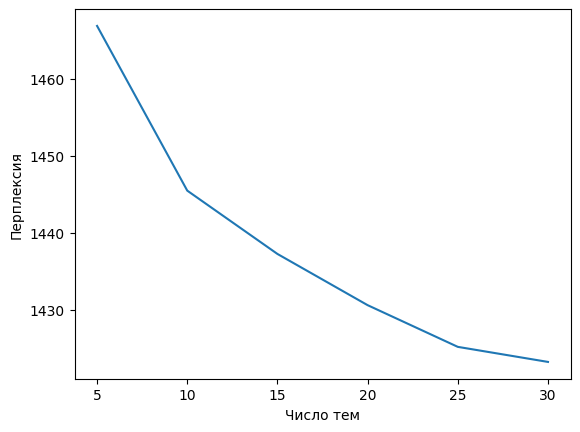

CPU times: user 4.89 s, sys: 172 ms, total: 5.06 s
Wall time: 2.94 s


In [8]:
%%time
topics_list = [5, 10, 15, 20, 25, 30]
perplexity = []

for num in tqdm(topics_list, total=len(topics_list)):
    plsa = artm.ARTM(num_topics=num, dictionary=batch_vectorizer.dictionary)
    plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
    plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
    plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    perplexity.append(plsa.score_tracker['perplexity_score'].value[-1])

plt.plot(topics_list, perplexity)
plt.xlabel('Число тем')
plt.ylabel('Перплексия')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/10 [00:00<?, ?it/s]

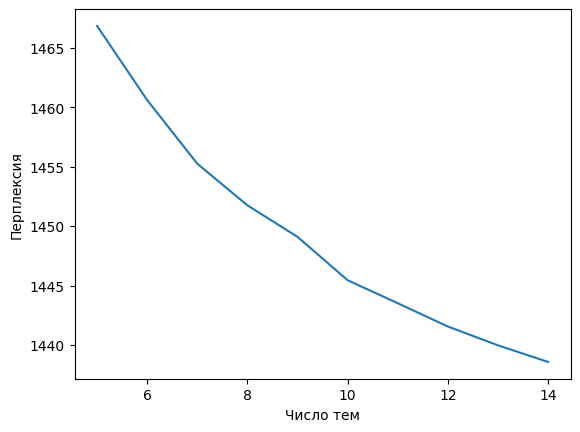

CPU times: user 7.3 s, sys: 259 ms, total: 7.56 s
Wall time: 6.88 s


In [9]:
%%time
perplexity = []

for num in tqdm(range(5, 15), total=10):
    plsa = artm.ARTM(num_topics=num, dictionary=batch_vectorizer.dictionary)
    plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
    plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
    plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    perplexity.append(plsa.score_tracker['perplexity_score'].value[-1])

plt.plot(range(5, 15), perplexity)
plt.xlabel('Число тем')
plt.ylabel('Перплексия')
plt.show()

In [10]:
plsa = artm.ARTM(num_topics=10, dictionary=batch_vectorizer.dictionary)
plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['заказ', 'доставка', 'интернет', 'сайт', 'цена', 'оплатить']
topic_1:  ['дом', 'адрес', 'квартира', 'год', 'работа', 'просить']
topic_2:  ['ребёнок', 'сказать', 'делать', 'тест', 'результат', 'человек']
topic_3:  ['средство', 'денежный', 'билет', '2022', 'ооо', '2021']
topic_4:  ['продавец', 'купить', 'качество', 'приобрести', 'вернуть', 'чек']
topic_5:  ['услуга', 'договор', 'это', 'который', 'право', 'мой']
topic_6:  ['карта', 'номер', 'сумма', 'мой', 'банк', 'почта']
topic_7:  ['это', 'просить', 'вода', 'принять', 'мы', 'горячий']
topic_8:  ['просить', 'добрый', 'площадка', 'область', 'какой', 'санитарный']
topic_9:  ['деньга', 'вернуть', 'ремонт', 'телефон', 'сказать', '2022']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Интерпритация тем:
1. Интернет торговля
2. Недвижимость
3. Дети
4. Финансы и бизнес
5. Торговля и качество товаров
6. Оказание услуг
7. Банковские услуги
8. ЖКХ
9. Санитария
10. Ремонт техники



